In [ ]:
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scvelo as scv
if torch.__version__[:4] == '1.14': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# sns.set_theme()
scv.set_figure_params('scvelo')  # for beautified visualization
%load_ext autoreload
%autoreload 2

Using device cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
dataset_name = "pancreas"

In [ ]:
# Load single cell dataset from scvelo and get associated information
from FRED.datasets import double_helix, directed_swiss_roll_delayed, directed_sinh_branch, rnavelo, rnavelo_pcs
from FRED.data_processing import ManifoldWithVectorField
from torch.utils.data import DataLoader
import scvelo as scv
import os
from pathlib import Path

# choose correct dataset
Xpath = f"data/{dataset_name}/processed/X.txt"
if os.path.exists(Xpath):
    X = np.loadtxt(Xpath)
    flow = np.loadtxt(f"data/{dataset_name}/processed/flow.txt")
    labels = np.loadtxt(f"data/{dataset_name}/processed/labels.txt")
    latent_time = np.loadtxt(f"data/{dataset_name}/processed/latent_time.txt")
else:
    if dataset_name == "bone marrow":
        adata = scv.datasets.bonemarrow()
    elif dataset_name == "dentategyrus":
        adata = scv.datasets.dentategyrus()
    elif dataset_name == "pancreas":
        adata = scv.datasets.pancreas()
    elif dataset_name == "dentategyrus_lamanno":
        adata = scv.datasets.dentategyrus_lamanno()
    print("processing data with pcs")
    X, flow, labels, n_pcs = rnavelo_pcs(adata)
    # dynamical recovery
    scv.tl.recover_dynamics(adata, n_jobs=1)
    scv.tl.latent_time(adata)
    latent_time = adata.obs['latent_time'].to_numpy()
    # save the processed data to np txt files for ready loading in the future
    Path(f"data/{dataset_name}/processed").mkdir(parents = True,exist_ok=True)
    np.savetxt(f"data/{dataset_name}/processed/X.txt",X)
    np.savetxt(f"data/{dataset_name}/processed/flow.txt",flow)
    np.savetxt(f"data/{dataset_name}/processed/labels.txt",labels)
    np.savetxt(f"data/{dataset_name}/processed/latent_time.txt",latent_time)


  0%|          | 0.00/50.0M [00:00<?, ?B/s]

processing data with pcs
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:07) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:19) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:05) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
recovering dynamics (using 1/10 cores)


  0%|          | 0/2290 [00:00<?, ?gene/s]

    finished (0:10:02) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:02) --> added 
    'latent_time', shared time (adata.obs)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


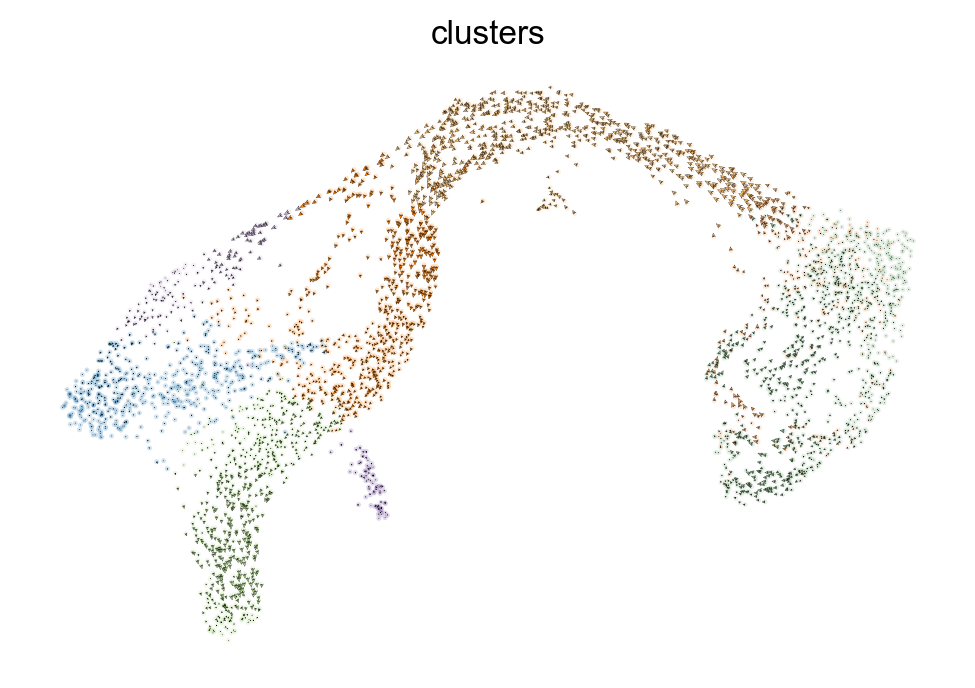

In [ ]:
# get umap embedding of data
scv.tl.umap(adata)
scv.pl.velocity_embedding(adata, basis='umap')

In [ ]:
import umap
reducer = umap.UMAP()
umap_coords = torch.tensor(reducer.fit_transform(X))

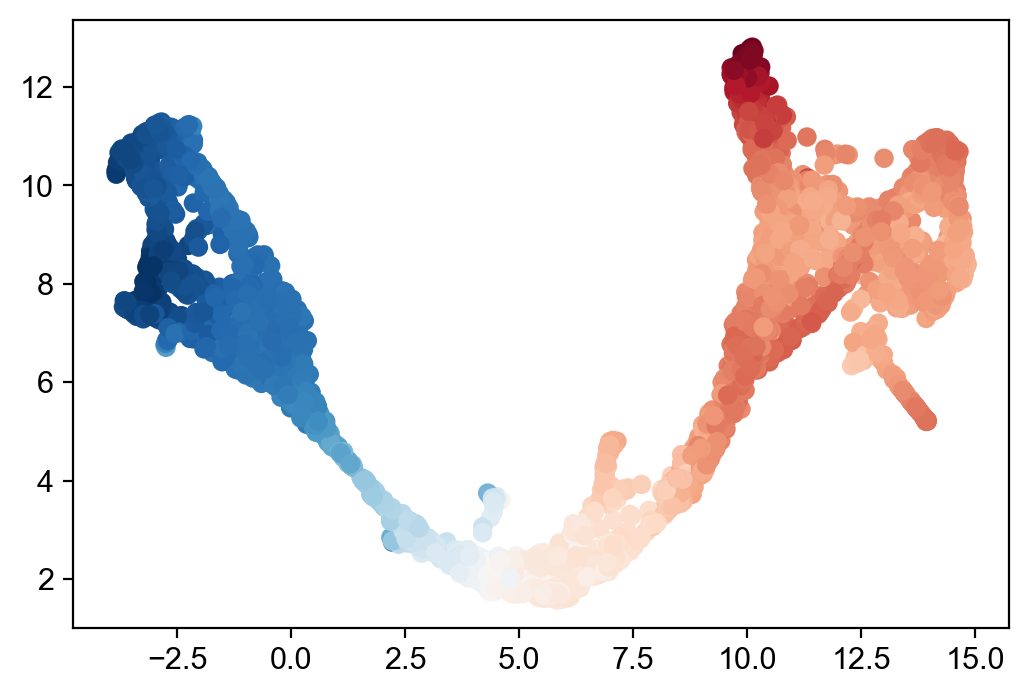

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(umap_coords[:,0],umap_coords[:,1], c=adata.obs['latent_time'].to_numpy())

In [ ]:
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'highly_variable_genes', 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'recover_dynamics', 'umap'
    obsm: 'X_pca', 'X_umap', 'velocity_pca', 'velocity_umap'
    varm: 'loss'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity', 'fit_t', 'fit_tau', 'fit_tau_'
    ob

In [ ]:
X_scv = adata.obsm['X_umap']

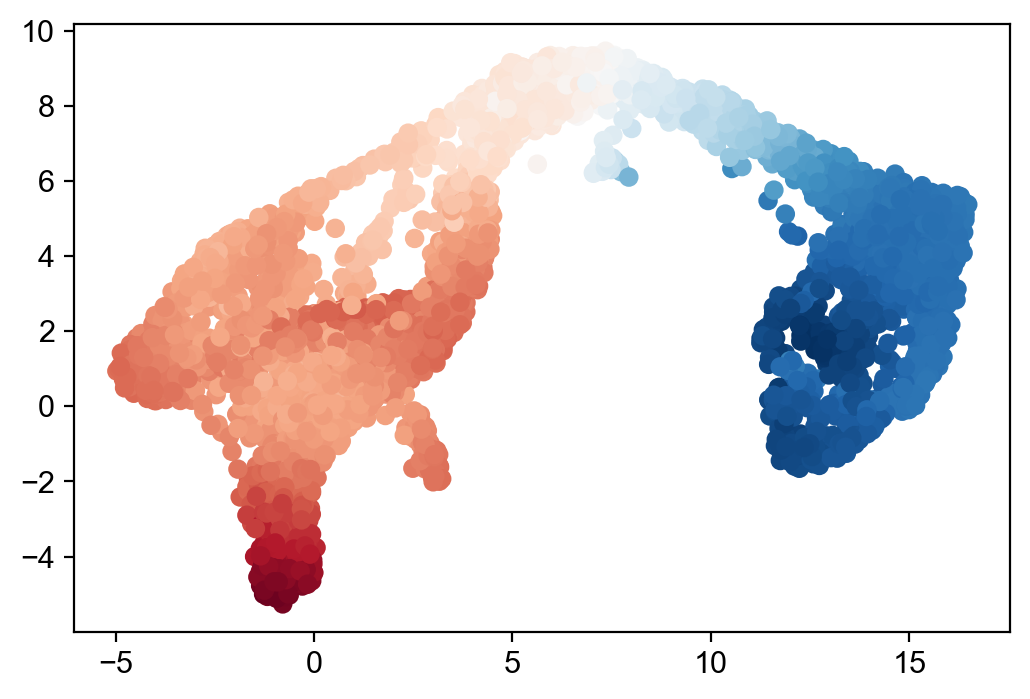

In [ ]:
plt.scatter(X_scv[:,0],X_scv[:,1], c=adata.obs['latent_time'].to_numpy())